In [1]:
!pip install underthesea
!pip install pyvi
!pip install regex
!pip install imblearn
!pip install vncorenlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=da3876b7d0c36176be3442047b751d625fa8694395df8857de27d72c2d805947
  Stored in directory: /root/.cache/pip/wheels/80/ad/d4/9e1a0939f63331a3898f2a951a368bbf0d69f7b027cae4d66b
Successfully built vncorenlp


# Connect to Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import re
import string
from collections import Counter

from vncorenlp import VnCoreNLP
from pyvi import ViTokenizer
import itertools
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

#Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from joblib import dump, load

#Model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Get data

In [4]:
def get_data(data_path_sents, data_path_sentiments):
    with open(data_path_sents, 'r', encoding='utf-8') as file:
        sents = file.readlines()
    with open(data_path_sentiments, 'r', encoding='utf-8') as file:
        sentiments = file.readlines()
    return pd.DataFrame({'sentences':sents, 'sentiments':sentiments})

In [5]:
train_data = get_data('/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/train-20241208T060932Z-001/sents.txt', '/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/train-20241208T060932Z-001/sentiments.txt')
test_data = get_data('/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/test-20241208T060919Z-001/sents.txt', '/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/test-20241208T060919Z-001/sentiments.txt')

In [6]:
print(train_data.shape)
print(test_data.shape)

(11426, 2)
(3166, 2)


# Preprocessing

## Sentiments

In [7]:
def process_sentiment(text):
    text = text.replace('\n', '')
    return text
train_data['sentiments'] = train_data['sentiments'].apply(lambda x: process_sentiment(str(x)))
train_data['sentiments'] = train_data['sentiments'].astype(int)

sentiments
2    5643
0    5325
1     458
Name: count, dtype: int64


<Axes: xlabel='sentiments'>

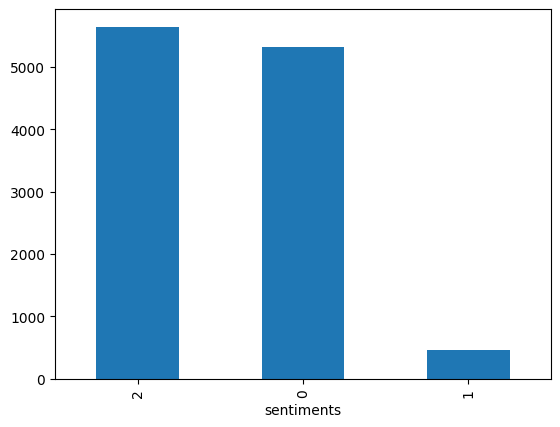

In [8]:
print(train_data['sentiments'].value_counts())
train_data['sentiments'].value_counts().plot.bar()

In [9]:
test_data['sentiments'] = test_data['sentiments'].apply(lambda x: process_sentiment(str(x)))
test_data['sentiments'] = test_data['sentiments'].astype(int)

sentiments
2    1590
0    1409
1     167
Name: count, dtype: int64


<Axes: xlabel='sentiments'>

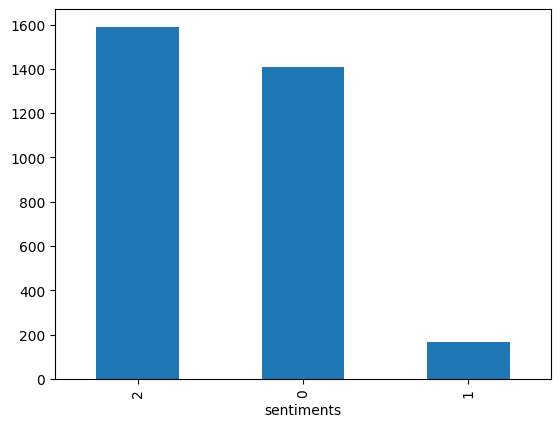

In [10]:
print(test_data['sentiments'].value_counts())
test_data['sentiments'].value_counts().plot.bar()

## Sentences

### Teencode, punctuation, numbers, lowercase

In [11]:
#LOAD TEENCODE
file = open('/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/file_preprocess/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()

#LOAD STOPWORDS
file = open('/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/file_preprocess/vietnamese-stopwords-dash.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [12]:
def process_text(text, dict_teen):
    document = text.lower() ##### LOWERCASE
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        ###### CONVERT TEENCODE
        sentence = ' '.join(dict_teen[word] if word in dict_teen else word for word in sentence.split())

        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))

        new_sentence = new_sentence + sentence

    document = new_sentence
     ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [13]:
train_data['sentences'] = train_data['sentences'].apply(lambda x: process_text(str(x), teen_dict))

In [14]:
test_data['sentences'] = test_data['sentences'].apply(lambda x: process_text(str(x), teen_dict))

### Process special word & postag

In [15]:
def process_special_word(text):
    new_text = ''
    text_lst = text.split()
    i= 0
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [16]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

In [17]:
train_data['sentences'] = train_data['sentences'].apply(lambda x: process_postag_thesea(str(x)))

In [18]:
test_data['sentences'] = test_data['sentences'].apply(lambda x: process_postag_thesea(str(x)))

### Remove stopwords

In [19]:
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [20]:
train_data['sentences'] = train_data['sentences'].apply(lambda x: remove_stopword(str(x), stopwords_lst))

In [21]:
test_data['sentences'] = test_data['sentences'].apply(lambda x: remove_stopword(str(x), stopwords_lst))

### Empty rows

In [22]:
def drop_empty_rows(df, column_name):
    df_cleaned = df[df[column_name] != ""]
    return df_cleaned

In [23]:
train_data = drop_empty_rows(train_data, 'sentences')

In [24]:
test_data = drop_empty_rows(test_data, 'sentences')

### Feature Engineering & SMOTE

sentiments
0    4613
2    4520
1     243
Name: count, dtype: int64


<Axes: xlabel='sentiments'>

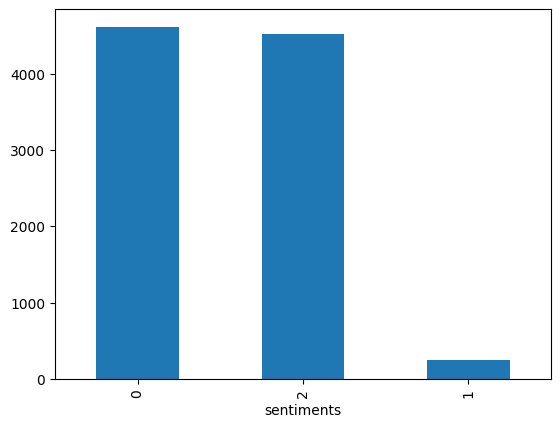

In [25]:
print(train_data['sentiments'].value_counts())
train_data['sentiments'].value_counts().plot.bar()

In [26]:
X = train_data['sentences']
y = train_data['sentiments']
X_test = test_data['sentences']
y_test = test_data['sentiments']

In [27]:
tfvectorizer = TfidfVectorizer()
X = tfvectorizer.fit_transform(X)
# Áp dụng SMOTE để tăng dữ liệu cho nhãn thiểu số
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [28]:
X_resampled_df = pd.DataFrame(X_resampled.toarray(), columns=tfvectorizer.get_feature_names_out())
y_resampled_df = pd.DataFrame(y_resampled, columns=['sentiments'])
print(y_resampled_df["sentiments"].value_counts())

sentiments
2    4613
0    4613
1    4613
Name: count, dtype: int64


In [29]:
X_test = tfvectorizer.transform(X_test)

# MultinomialNB

In [30]:
nb = MultinomialNB()
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}
MNBgrid_search = GridSearchCV(estimator=nb, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
MNBgrid_search.fit(X_resampled, y_resampled)
print(MNBgrid_search.best_score_)
print("Best parameters:", MNBgrid_search.best_params_)
best_mnb = MNBgrid_search.best_estimator_

0.7702866515142336
Best parameters: {'alpha': 0.1, 'fit_prior': True}


In [31]:
dump(best_mnb, '/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/model_save/best_mnb.pkl')

['/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/model_save/best_mnb.pkl']

## Evaluation

In [32]:
best_mnb = load('/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/model_save/best_mnb.pkl')
y_pred_mnb = best_mnb.predict(X_test)
acc_train = accuracy_score(y_true=y_resampled, y_pred=best_mnb.predict(X_resampled))
accuracy = accuracy_score(y_test, y_pred_mnb)
precision = precision_score(y_test, y_pred_mnb, average='weighted')
recall = recall_score(y_test, y_pred_mnb, average='weighted')
f1 = f1_score(y_test, y_pred_mnb, average='weighted')
print(f"Accuracy_train: {acc_train:.2f}")
print(f"Accuracy_test: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy_train: 0.82
Accuracy_test: 0.73
Precision: 0.78
Recall: 0.73
F1 Score: 0.75


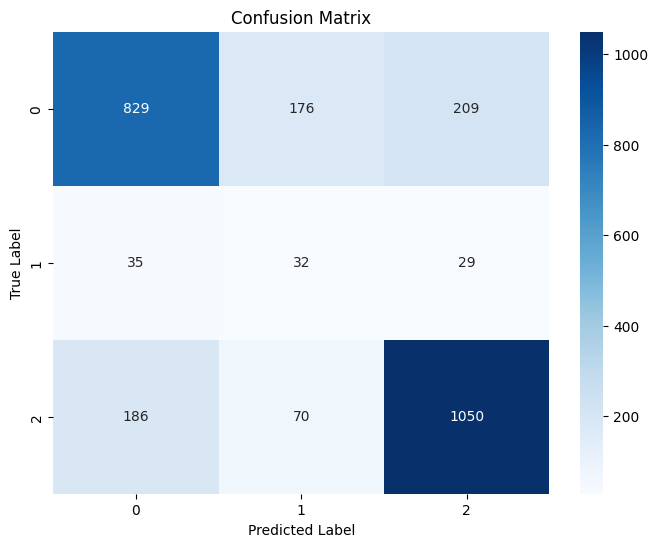

     0    1     2
0  829  176   209
1   35   32    29
2  186   70  1050


In [33]:
cm = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=MNBgrid_search.classes_, yticklabels=MNBgrid_search.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print(pd.DataFrame(cm))

# RandomForestClassifier

In [34]:
param_grid = {
    'max_depth': [3,5,7,10],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [10, 20, 30 , 40],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}
RFmodel = RandomForestClassifier()
RFgrid_search = GridSearchCV(estimator=RFmodel, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
RFgrid_search.fit(X_resampled, y_resampled)
print('Best score:', RFgrid_search.best_score_)
print("Best parameters:", RFgrid_search.best_params_)
best_RF = RFgrid_search.best_estimator_

Best score: 0.7762122642790443
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 400}


In [35]:
dump(best_RF, '/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/model_save/best_RF.pkl')

['/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/model_save/best_RF.pkl']

## Evaluation

In [36]:
best_RF = load('/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/model_save/best_RF.pkl')
y_pred_RF = best_RF.predict(X_test)
acc_train = accuracy_score(y_true=y_resampled, y_pred=best_RF.predict(X_resampled))
accuracy = accuracy_score(y_test, y_pred_RF)
precision = precision_score(y_test, y_pred_RF, average='weighted')
recall = recall_score(y_test, y_pred_RF, average='weighted')
f1 = f1_score(y_test, y_pred_RF, average='weighted')
print(f"Accuracy_train: {acc_train:.2f}")
print(f"Accuracy_test: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy_train: 0.81
Accuracy_test: 0.74
Precision: 0.76
Recall: 0.74
F1 Score: 0.75


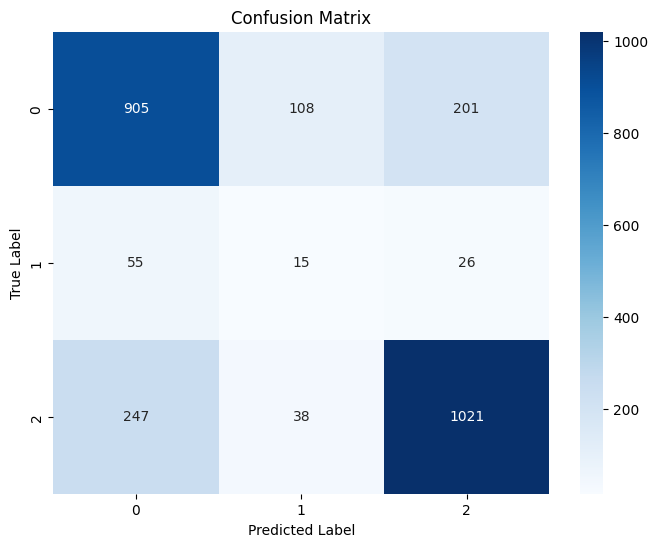

     0    1     2
0  905  108   201
1   55   15    26
2  247   38  1021


In [37]:
cm = confusion_matrix(y_test, y_pred_RF)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_RF.classes_, yticklabels=best_RF.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print(pd.DataFrame(cm))

# XGBoostClassifier

In [39]:
param_grid = {
  'n_estimators':[50,100,200],
  'learning_rate':[0.01,0.05,0.1],
  'max_depth':[3,5,7],
  'reg_alpha': [0, 0.1, 1],
  'reg_lambda': [1, 1.5, 2]
}
xgb_model = xgb.XGBClassifier()
XGBgrid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
XGBgrid_search.fit(X_resampled, y_resampled)
print('Best score:', XGBgrid_search.best_score_)
print("Best parameters:", XGBgrid_search.best_params_)
best_XGB = XGBgrid_search.best_estimator_

Best score: 0.8064893898151417
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1}


In [40]:
dump(best_XGB, '/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/model_save/best_XGB.pkl')

['/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/model_save/best_XGB.pkl']

## Evaluation

In [41]:
best_XGB = load('/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/model_save/best_XGB.pkl')
y_pred_XGB = best_XGB.predict(X_test)
acc_train = accuracy_score(y_true=y_resampled, y_pred=best_XGB.predict(X_resampled))
accuracy = accuracy_score(y_test, y_pred_XGB)
precision = precision_score(y_test, y_pred_XGB, average='weighted')
recall = recall_score(y_test, y_pred_XGB, average='weighted')
f1 = f1_score(y_test, y_pred_XGB, average='weighted')
print(f"Accuracy_train: {acc_train:.2f}")
print(f"Accuracy_test: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy_train: 0.84
Accuracy_test: 0.75
Precision: 0.76
Recall: 0.75
F1 Score: 0.75


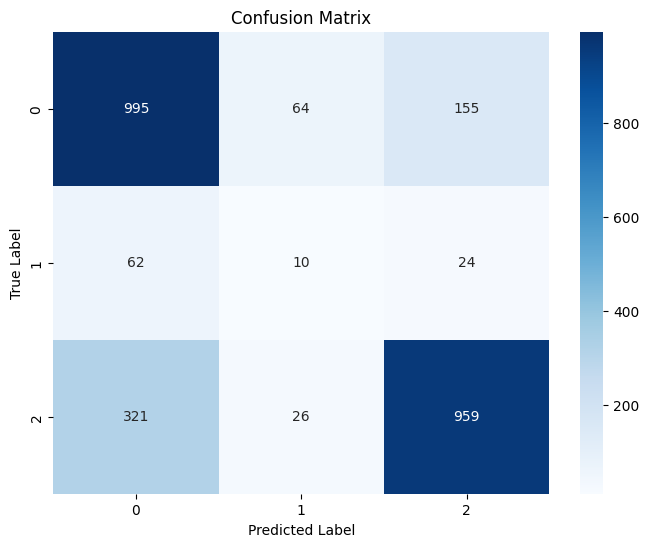

     0   1    2
0  995  64  155
1   62  10   24
2  321  26  959


In [42]:
cm = confusion_matrix(y_test, y_pred_XGB)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_XGB.classes_, yticklabels=best_XGB.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print(pd.DataFrame(cm))